In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from random import shuffle
import cv2
from ipynb.fs.full.read_data import *

# cnt=0
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         path=os.path.join(subdir, file)
#         num=path.split('(')[0]
#         sec_num=num.split('/')
#         #print(int(sec_num[1][0:3]))
#         cnt+=1
# print(cnt)  
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'genderRecog-param-tun-epochs-noting-training-acc-testing-and-loss-{}-{}.model'.format(LR, 'CNN')

In [2]:
# def label_img(img):
#     num=img.split('(')[0]
#     sec_num=num.split('/')
#     my_num=int(sec_num[1][0:3])
#     if my_num >= 1 and my_num <= 98:
#         return [1,0]
#     elif my_num >= 99 and my_num <=164:
#         return [0,1]

In [3]:
# def create_data():
#     data = []
#     for subdir, dirs, files in os.walk(rootdir):
#         for file in files:
#             #print(file)
            
#             path=os.path.join(subdir, file)
#             label=label_img(path)
#             file = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
            
#             data.append([np.array(file),np.array(label)])
            
#     shuffle(data)
#     #print(data[0])
#     return data

In [4]:
#create_data()

data = create_data()

In [5]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.reset_default_graph()
#Pooling layers are a way to reduce the size 
#of the image interpretation in order to speed up computation,
#and it makes the detected features more robust.

#Here max_pooling is used

#pooling is a way to prevent overfitting, since we are removing some features from the input image.

# input layer will be 50*50
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
# 2 neurons in the output layer(Male/female)
convnet = fully_connected(convnet, 2, activation='softmax')
#Categorical crossentropy is a loss function that is used for single label
#categorization. This is when only one category is applicable for each data point. 
#In other words, an example can belong to one class only.
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')
import warnings
warnings.filterwarnings('ignore')

C:\Users\priya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\priya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\priya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\priya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

curses is not supported on this machine (please install/reinstall curses for an optimal experience)







Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [33]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\priya\Documents\Gender-Recog\genderRecog-param-tun-epochs-noting-training-acc-testing-and-loss-0.001-CNN.model
model loaded!


In [7]:
train = data[:-7000]
test = data[-7000:]

In [8]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]



In [9]:
epochs = []
for i in range(1,12):
    epochs.append(i)
    
epochs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [10]:
my_val_acc = []
my_loss = []
# val_loss and val_acc are taken from saved checkpoints,
#due to absence of varible related to traing accuracy and loss, had to collect them manually
for i in epochs:
    model.fit({'input': X}, {'targets': Y}, n_epoch=i, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
    model.save(MODEL_NAME)
    my_val_acc.append(tf.train.load_variable(
    "./", 'val_acc'
    ))
    my_loss.append(tf.train.load_variable(
    "./", 'val_loss'
    ))

Training Step: 22109  | total loss: 0.06397 | time: 15.716s
| Adam | epoch: 066 | loss: 0.06397 - acc: 0.9763 -- iter: 21376/21412
Training Step: 22110  | total loss: 0.06182 | time: 17.281s
| Adam | epoch: 066 | loss: 0.06182 - acc: 0.9771 | val_loss: 0.87802 - val_acc: 0.8493 -- iter: 21412/21412
--
INFO:tensorflow:C:\Users\priya\Documents\Gender-Recog\genderRecog-param-tun-epochs-noting-training-acc-testing-and-loss-0.001-CNN.model is not in all_model_checkpoint_paths. Manually adding it.


In [11]:
tf.train.load_variable(
    "./", 'val_acc'
)

0.8492857

In [12]:
my_val_acc

[0.78985715,
 0.79242855,
 0.8297143,
 0.8618571,
 0.8511429,
 0.86142856,
 0.86,
 0.8495714,
 0.8582857,
 0.84485716,
 0.8492857]

In [13]:
my_loss

[0.4659406,
 0.43729535,
 0.3878984,
 0.33754066,
 0.37264317,
 0.41655797,
 0.5370079,
 0.6318699,
 0.67125565,
 0.80463576,
 0.8780186]

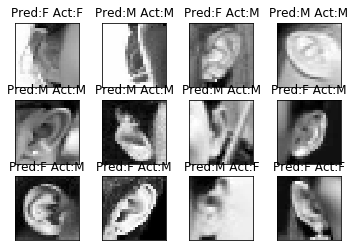

In [31]:
import matplotlib.pyplot as plt
test = data[-500:]
shuffle(test)
# for num,my_data in enumerate(test[:100]):
#     print(num)
#     print(my_data[1])

fig=plt.figure()

for num,my_data in enumerate(test[:12]):
    
    
    img_num = my_data[1]
    img_data = my_data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    my_data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([my_data])[0]
    
    if np.argmax(model_out) == 1: str_label='Pred:F'
    else: str_label='Pred:M'
    if img_num[0] == 1: my_label=' Act:M'
    else:
        my_label=' Act:F'
    y.imshow(orig,cmap='gray')
    plt.title(str_label+my_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [15]:
# tf.train.load_variable(
#     "./",'val_acc'
# )

In [16]:
# my_list=[]
# my_list.append(tf.train.load_variable(
#     "./", 'val_loss'
# ))

In [17]:
# my_list

In [18]:
# epochs

In [19]:
# act_epochs=[1]
# for i in range(1,11):
#     act_epochs.append(epochs[i]+act_epochs[i-1])

In [ ]:
# plt.plot(act_epochs, my_val_acc, color='red')
# plt.xlabel('No. of epochs')
# plt.ylabel('Validation Accuarcy')
# plt.title('Variation in val_acc with no. of epochs')
# plt.show()

In [ ]:
# plt.plot(act_epochs, my_loss, color='green')
# plt.xlabel('No. of epochs')
# plt.ylabel('Validation Loss')
# plt.title('Variation in val_loss with no. of epochs')
# plt.show()

### val_loss starts increasing, val_acc starts decreasing. This means model is cramming values not learning

### val_loss starts increasing, val_acc also increases.This could be case of overfitting or diverse probability values in cases where softmax is being used in output layer

### val_loss starts decreasing, val_acc starts increasing. This is also fine as that means model built is learning and working fine.

#### So here, it can be seen that for 15 epochs the loss is low and validation accuarcy is high, for further epochs either the model is overfitting or cramming the values not learning (case 1)

In [ ]:
import tensorflow as tf
tf.train.list_variables(
    './'
)

In [ ]:
# tf.train.load_variable(
#     "./",'Conv2D_1/W/Adam_1'
# )

In [21]:
val_acc_new=[0.72642857,
 0.813,
 0.84685713,
 0.85342854,
 0.8582857,
 0.8547143,
 0.86457145,
 0.85785717,
 0.86228573,
 0.86471426,
 0.8442857]

In [23]:
acc_new = [0.789,0.8605,0.8856,0.915,0.9229,0.9486,0.959,0.9794,0.9764,0.9817,0.9788]

In [24]:
val_loss_new = [0.5978138,
 0.41176006,
 0.35686368,
 0.35674706,
 0.3801074,
 0.39777866,
 0.43902338,
 0.6032892,
 0.6555452,
 0.66388255,
 0.5937399]

In [25]:
loss_new = [0.47,0.32,0.29,0.20,0.16,0.14,0.10,0.06,0.06,0.04,0.14]

In [26]:
act_epochs=[1, 3, 6, 10, 15, 21, 28, 36, 45, 55, 66]

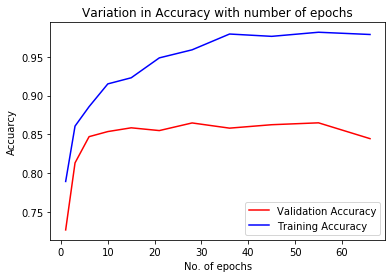

In [28]:
plt.plot(act_epochs, val_acc_new, color='red', label='Validation Accuracy')
plt.plot(act_epochs, acc_new, color='blue', label='Training Accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('Accuarcy')
plt.title('Variation in Accuracy with number of epochs')
plt.legend()
plt.show()

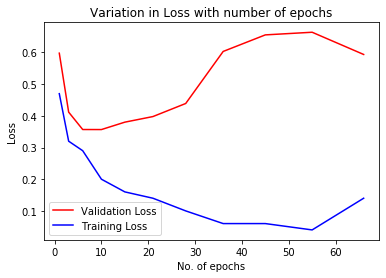

In [29]:
plt.plot(act_epochs, val_loss_new, color='red',label='Validation Loss')
plt.plot(act_epochs, loss_new, color='blue',label='Training Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.title('Variation in Loss with number of epochs')
plt.legend()
plt.show()

In [30]:
help(conv_2d)

Help on function conv_2d in module tflearn.layers.conv:

conv_2d(incoming, nb_filter, filter_size, strides=1, padding='same', activation='linear', bias=True, weights_init='uniform_scaling', bias_init='zeros', regularizer=None, weight_decay=0.001, trainable=True, restore=True, reuse=False, scope=None, name='Conv2D')
    Convolution 2D.
    
    Input:
        4-D Tensor [batch, height, width, in_channels].
    
    Output:
        4-D Tensor [batch, new height, new width, nb_filter].
    
    Arguments:
        incoming: `Tensor`. Incoming 4-D Tensor.
        nb_filter: `int`. The number of convolutional filters.
        filter_size: `int` or `list of int`. Size of filters.
        strides: 'int` or list of `int`. Strides of conv operation.
            Default: [1 1 1 1].
        padding: `str` from `"same", "valid"`. Padding algo to use.
            Default: 'same'.
        activation: `str` (name) or `function` (returning a `Tensor`) or None.
            Activation applied to this lay

In [34]:
 tf.train.list_variables("./")

[('Accuracy/Mean/moving_avg', []),
 ('Adam/beta1_power', []),
 ('Adam/beta2_power', []),
 ('Conv2D/W', [5, 5, 1, 32]),
 ('Conv2D/W/Adam', [5, 5, 1, 32]),
 ('Conv2D/W/Adam_1', [5, 5, 1, 32]),
 ('Conv2D/b', [32]),
 ('Conv2D/b/Adam', [32]),
 ('Conv2D/b/Adam_1', [32]),
 ('Conv2D_1/W', [5, 5, 32, 64]),
 ('Conv2D_1/W/Adam', [5, 5, 32, 64]),
 ('Conv2D_1/W/Adam_1', [5, 5, 32, 64]),
 ('Conv2D_1/b', [64]),
 ('Conv2D_1/b/Adam', [64]),
 ('Conv2D_1/b/Adam_1', [64]),
 ('Conv2D_2/W', [5, 5, 64, 128]),
 ('Conv2D_2/W/Adam', [5, 5, 64, 128]),
 ('Conv2D_2/W/Adam_1', [5, 5, 64, 128]),
 ('Conv2D_2/b', [128]),
 ('Conv2D_2/b/Adam', [128]),
 ('Conv2D_2/b/Adam_1', [128]),
 ('Conv2D_3/W', [5, 5, 128, 256]),
 ('Conv2D_3/W/Adam', [5, 5, 128, 256]),
 ('Conv2D_3/W/Adam_1', [5, 5, 128, 256]),
 ('Conv2D_3/b', [256]),
 ('Conv2D_3/b/Adam', [256]),
 ('Conv2D_3/b/Adam_1', [256]),
 ('Conv2D_4/W', [5, 5, 256, 128]),
 ('Conv2D_4/W/Adam', [5, 5, 256, 128]),
 ('Conv2D_4/W/Adam_1', [5, 5, 256, 128]),
 ('Conv2D_4/b', [128]),
 (